In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import random as rn
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 시드 설정
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# XGBoost 버전 확인
print(f"XGBoost 버전: {xgboost.__version__}")

print("🚀 전력 사용량 예측 앙상블 모델 V3 시작!")
print("=" * 50)


XGBoost 버전: 1.6.1
🚀 전력 사용량 예측 앙상블 모델 V3 시작!


In [2]:
# 전체 데이터 기간 확인
print("🧪 전체 데이터 기간 확인...")

# 데이터 로드
train = pd.read_csv('data/train.csv')
train = train.rename(columns={'일시': 'date_time'})
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

print(f"📅 전체 train 데이터 기간: {train['date_time'].min()} ~ {train['date_time'].max()}")
print(f"📊 전체 train 데이터 수: {len(train)}개")
print(f"📊 총 기간: {(train['date_time'].max() - train['date_time'].min()).days}일")
print(f"📊 총 주차: {(train['date_time'].max() - train['date_time'].min()).days // 7}주")

# 건물 1개의 전체 데이터로 테스트
building_1_data = train[train['건물번호'] == 1].copy()
print(f"\\n📊 건물 1 데이터: {len(building_1_data)}개")
print(f"📅 건물 1 기간: {building_1_data['date_time'].min()} ~ {building_1_data['date_time'].max()}")
print(f"📊 건물 1 총 기간: {(building_1_data['date_time'].max() - building_1_data['date_time'].min()).days}일")
print(f"📊 건물 1 총 주차: {(building_1_data['date_time'].max() - building_1_data['date_time'].min()).days // 7}주")


🧪 전체 데이터 기간 확인...
📅 전체 train 데이터 기간: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
📊 전체 train 데이터 수: 204000개
📊 총 기간: 84일
📊 총 주차: 12주
\n📊 건물 1 데이터: 2040개
📅 건물 1 기간: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
📊 건물 1 총 기간: 84일
📊 건물 1 총 주차: 12주


In [3]:
def smape(gt, preds):
    """SMAPE (Symmetric Mean Absolute Percentage Error) 계산"""
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score
    
def weighted_mse(alpha=1):
    """가중 MSE 손실 함수 (Under-prediction에 더 큰 페널티)"""
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    """XGBoost용 SMAPE 평가 함수"""
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

print("✅ 평가 함수 정의 완료")


✅ 평가 함수 정의 완료


In [4]:
# 데이터 로드
print("📊 데이터 로드 중...")
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"✅ Train 데이터: {train.shape}")
print(f"✅ Test 데이터: {test.shape}")
print(f"✅ Building info: {building_info.shape}")

# 컬럼명 영어로 변경 (작년 수상자 방식)
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis=1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation'
})
test.drop('num_date_time', axis=1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

# 건물 유형 영어로 번역
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department Store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# 태양광/ESS 설비 유무 피처 생성
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity != '-', 1, 0)
building_info['ess_utility'] = np.where(building_info.ess_capacity != '-', 1, 0)

# 건물 정보 병합
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

print("✅ 기본 전처리 완료")


📊 데이터 로드 중...
✅ Train 데이터: (204000, 10)
✅ Test 데이터: (16800, 7)
✅ Building info: (100, 7)
✅ 기본 전처리 완료


In [5]:
# 날짜/시간 변환 및 기본 시간 피처 생성
print("🔧 Feature Engineering 시작...")

train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# 기본 시간 피처
for df in [train, test]:
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.dayofweek

print("✅ 기본 시간 피처 생성 완료")


🔧 Feature Engineering 시작...
✅ 기본 시간 피처 생성 완료


In [6]:
# 일별 온도 통계 피처 생성
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    """일별 통계값 계산 함수"""
    result_dict = {}
    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)
    
    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value
    
    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

# 일별 온도 통계 피처 생성
for df in [train, test]:
    calculate_day_values(df, 'temperature', 'day_max_temperature', 'max')
    calculate_day_values(df, 'temperature', 'day_mean_temperature', 'mean')
    calculate_day_values(df, 'temperature', 'day_min_temperature', 'min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']

print("✅ 일별 온도 통계 피처 생성 완료")


✅ 일별 온도 통계 피처 생성 완료


In [7]:
# 이상치 제거 및 추가 피처 생성 (0 제거)
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print(f"제거할 이상치 개수: {len(outlier_idx)}")
train.drop(index=outlier_idx, inplace=True)
print(f"남은 행 개수: {train.shape[0]}")

제거할 이상치 개수: 68
남은 행 개수: 203932


In [8]:
# 이상치 제거 (Z-score 기반 )
import numpy as np
from scipy import stats

def detect_outliers_zscore_only(train, threshold=4.5):
    """
    Z-score 방법으로만 이상치를 찾아내는 함수
    
    Args:
        train (pd.DataFrame): 전처리된 전체 학습 데이터
        threshold (float): Z-score 임계값 (기본값: 3)
    
    Returns:
        pd.DataFrame: 이상치 데이터
    """
    print(f"�� Z-score 방법으로 이상치 탐지 (임계값: {threshold})")
    print("=" * 60)
    
    outliers_list = []
    
    for building_num in train['building_number'].unique():
        building_data = train[train['building_number'] == building_num]['power_consumption']
        
        # Z-score 계산
        z_scores = np.abs(stats.zscore(building_data))
        
        # 임계값을 초과하는 이상치 찾기
        building_outliers = train[(train['building_number'] == building_num) & 
                                          (z_scores > threshold)]
        
        if not building_outliers.empty:
            outliers_list.append(building_outliers)
    
    outliers_df = pd.concat(outliers_list) if outliers_list else pd.DataFrame()
    
    print(f"📊 발견된 이상치: {len(outliers_df)}개")
    
    if not outliers_df.empty:
        print(f"�� 이상치가 있는 건물 수: {outliers_df['building_number'].nunique()}개")
        print(f"🏢 이상치가 있는 건물 번호: {sorted(outliers_df['building_number'].unique())}")
        
        # 건물별 이상치 개수
        building_counts = outliers_df['building_number'].value_counts()
        print(f"\n📈 건물별 이상치 개수:")
        for building_num, count in building_counts.items():
            building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
            print(f"   건물 {building_num} ({building_type}): {count}개")
    else:
        print("✅ 이상치가 발견되지 않았습니다.")
    
    return outliers_df

# Z-score 이상치 탐지 실행
outliers_df = detect_outliers_zscore_only(train, threshold=4.5)

# 이상치 상세 분석
if not outliers_df.empty:
    print(f"\n📊 이상치 상세 분석:")
    print("=" * 60)
    
    for building_num in sorted(outliers_df['building_number'].unique()):
        building_outliers = outliers_df[outliers_df['building_number'] == building_num]
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        
        print(f"\n🏢 건물 {building_num} ({building_type}):")
        print(f"   이상치 개수: {len(building_outliers)}개")
        print(f"   최소 전력소비량: {building_outliers['power_consumption'].min():.2f} kWh")
        print(f"   최대 전력소비량: {building_outliers['power_consumption'].max():.2f} kWh")
        print(f"   평균 전력소비량: {building_outliers['power_consumption'].mean():.2f} kWh")
        
        # 전체 건물 데이터와 비교
        building_all = train[train['building_number'] == building_num]
        print(f"   전체 데이터 평균: {building_all['power_consumption'].mean():.2f} kWh")
        print(f"   이상치 비율: {len(building_outliers)/len(building_all)*100:.2f}%")

�� Z-score 방법으로 이상치 탐지 (임계값: 4.5)
📊 발견된 이상치: 68개
�� 이상치가 있는 건물 수: 11개
🏢 이상치가 있는 건물 번호: [23, 30, 41, 43, 52, 64, 67, 72, 76, 81, 99]

📈 건물별 이상치 개수:
   건물 67 (IDC): 48개
   건물 41 (Commercial): 4개
   건물 43 (IDC): 4개
   건물 30 (IDC): 2개
   건물 52 (IDC): 2개
   건물 76 (Commercial): 2개
   건물 99 (Commercial): 2개
   건물 23 (Research Institute): 1개
   건물 64 (IDC): 1개
   건물 72 (Public): 1개
   건물 81 (IDC): 1개

📊 이상치 상세 분석:

🏢 건물 23 (Research Institute):
   이상치 개수: 1개
   최소 전력소비량: 9324.00 kWh
   최대 전력소비량: 9324.00 kWh
   평균 전력소비량: 9324.00 kWh
   전체 데이터 평균: 2339.77 kWh
   이상치 비율: 0.05%

🏢 건물 30 (IDC):
   이상치 개수: 2개
   최소 전력소비량: 2444.40 kWh
   최대 전력소비량: 7374.24 kWh
   평균 전력소비량: 4909.32 kWh
   전체 데이터 평균: 9801.04 kWh
   이상치 비율: 0.10%

🏢 건물 41 (Commercial):
   이상치 개수: 4개
   최소 전력소비량: 246.24 kWh
   최대 전력소비량: 2102.94 kWh
   평균 전력소비량: 1373.76 kWh
   전체 데이터 평균: 2710.89 kWh
   이상치 비율: 0.20%

🏢 건물 43 (IDC):
   이상치 개수: 4개
   최소 전력소비량: 834.60 kWh
   최대 전력소비량: 9765.60 kWh
   평균 전력소비량: 5587.50 kWh
   전체 데이터 평균: 14058.8

In [9]:
def drop_outliers_safe(train, outliers_df):
    """
    안전한 방법으로 이상치 제거 (모든 컬럼 매칭)
    
    Args:
        train (pd.DataFrame): 전체 학습 데이터
        outliers_df (pd.DataFrame): 이상치 데이터
    
    Returns:
        pd.DataFrame: 이상치가 제거된 데이터
    """
    print(f"🔍 안전한 이상치 제거 시작")
    print(f"   원본 데이터 크기: {len(train)}개")
    print(f"   제거할 이상치 개수: {len(outliers_df)}개")
    
    # 정제된 데이터 초기화
    cleaned_data = train.copy()
    
    # 이상치가 있는 건물들만 처리
    outlier_buildings = outliers_df['building_number'].unique()
    
    removed_count = 0
    for building_num in outlier_buildings:
        building_outliers = outliers_df[outliers_df['building_number'] == building_num]
        
        # 해당 건물의 데이터에서 이상치 제거
        building_mask = cleaned_data['building_number'] == building_num
        
        for _, outlier_row in building_outliers.iterrows():
            # 정확히 일치하는 행 찾기
            match_mask = (
                (cleaned_data['building_number'] == outlier_row['building_number']) &
                (cleaned_data['date_time'] == outlier_row['date_time']) &
                (cleaned_data['power_consumption'] == outlier_row['power_consumption'])
            )
            
            # 일치하는 행 제거
            cleaned_data = cleaned_data[~match_mask]
            removed_count += match_mask.sum()
    
    print(f"   제거 후 데이터 크기: {len(cleaned_data)}개")
    print(f"   실제 제거된 행 수: {removed_count}개")
    print(f"   제거된 데이터 비율: {removed_count/len(train)*100:.2f}%")
    
    return cleaned_data

# 안전한 이상치 제거 실행
train = drop_outliers_safe(train, outliers_df)

# 결과 확인
print(f"\n📊 안전한 이상치 제거 결과:")
print(f"   확인: {len(train)}개")

# 정제된 데이터를 새로운 변수에 저장
print(f"\n✅ train 변수에 정제된 데이터가 저장되었습니다.")

🔍 안전한 이상치 제거 시작
   원본 데이터 크기: 203932개
   제거할 이상치 개수: 68개
   제거 후 데이터 크기: 203864개
   실제 제거된 행 수: 68개
   제거된 데이터 비율: 0.03%

📊 안전한 이상치 제거 결과:
   확인: 203864개

✅ train 변수에 정제된 데이터가 저장되었습니다.


In [10]:
# 공휴일(holiday), 주말(weekend), 닫은날(close)로 세분화# 

In [11]:
# 1. 기본 공휴일 및 주말 피처 생성
holi_weekday = ['2024-06-06', '2024-08-15']  # 공휴일 목록
for df in [train, test]:
    # 공휴일 (국가 공휴일)
    df['holiday'] = np.where(
        df.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday), 1, 0
    )
    
    # 주말 (토요일, 일요일)
    df['weekend'] = np.where(
        df.day_of_week >= 5, 1, 0
    )
    
    # 닫은날 (초기값 0으로 설정, 나중에 건물별 규칙 적용)
    df['close'] = 0


# 주기성 피처 생성 (Cyclical Features)
for df in [train, test]:
    # 시간 주기성
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 23.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 23.0)
    
    # 날짜 주기성
    df['sin_date'] = -np.sin(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    df['cos_date'] = -np.cos(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    
    # 월 주기성
    df['sin_month'] = -np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = -np.cos(2 * np.pi * df['month'] / 12.0)
    
    # 요일 주기성
    df['sin_dayofweek'] = -np.sin(2 * np.pi * (df['day_of_week'] + 1) / 7.0)
    df['cos_dayofweek'] = -np.cos(2 * np.pi * (df['day_of_week'] + 1) / 7.0)



In [12]:
def apply_specific_building_holidays(df):
    """
    특정 건물들의 휴일 규칙을 적용하는 함수
    - 18번 건물: 매주 일요일 휴무 (close)
    - 27, 40, 59, 63번 건물: 홀수 주 일요일 휴무 (close)
    - 29번 건물: 매달 10일 + 5번째 주 일요일 휴무 (close)
    - 32번 건물: 홀수 주 월요일 휴무 (close)
    """
    print("🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)")
    department_store_buildings = building_info[building_info['building_type'] == 'Department Store']['building_number'].tolist()

    # 매주 일요일 휴무 건물 (18번)
    every_sunday_buildings = [18]

    # 홀수 주 일요일 휴무 건물들 (27, 40, 59, 63)
    odd_week_sunday_buildings = [27, 40, 59, 63]

    # 매달 10일 + 5번째 주 일요일 휴무 건물 (29)
    special_holiday_building = [29]

    # 홀수 주 월요일 휴무 건물 (32)
    odd_week_monday_buildings = [32]

    # 달력 기준 주차 계산 (일요일 시작)
    def get_calendar_week_of_month(date_series):
        """달력 기준 주차 계산 (월의 첫날이 포함된 주를 1주차로)"""
        result = []
        for date in date_series:
            first_day = date.replace(day=1)
            first_day_weekday = first_day.weekday()
            days_to_week_start = (first_day_weekday + 1) % 7  # 일요일 기준
            week_start_of_first = first_day - pd.Timedelta(days=days_to_week_start)
            days_since_first_week_start = (date - week_start_of_first).days
            week_num = (days_since_first_week_start // 7) + 1
            result.append(week_num)
        return result

    # 달력 기준 주차 계산
    df['calendar_week_of_month'] = get_calendar_week_of_month(df['date_time'])

    # 0. 매주 일요일 휴무 (18번 건물) - close에 적용
    for building_num in every_sunday_buildings:
        mask = (df['building_number'] == building_num) & (df['day_of_week'] == 6)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 매주 일요일 휴일 {count}개 적용")

    # 1. 홀수 주 일요일 휴무 (27, 40, 59, 63번 건물) - close에 적용
    for building_num in odd_week_sunday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 6) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 일요일 휴일 {count}개 적용")

    # 2. 매달 10일 + 5번째 주 일요일 휴무 (29번 건물) - close에 적용
    for building_num in special_holiday_building:
        mask_10th = (df['building_number'] == building_num) & (df['date_time'].dt.day == 10)
        df.loc[mask_10th, 'close'] = 1
        count_10th = mask_10th.sum()
        mask_5th_sunday = (df['building_number'] == building_num) & \
                          (df['day_of_week'] == 6) & \
                          (df['calendar_week_of_month'] == 5)
        df.loc[mask_5th_sunday, 'close'] = 1
        count_5th_sunday = mask_5th_sunday.sum()
        print(f"   건물 {building_num}: 매달 10일 휴일 {count_10th}개, 5번째 주 일요일 {count_5th_sunday}개 적용")

    # 3. 홀수 주 월요일 휴무 (32번 건물) - close에 적용
    for building_num in odd_week_monday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 0) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 월요일 휴일 {count}개 적용")

    # 임시 컬럼 제거
    df.drop(['calendar_week_of_month'], axis=1, inplace=True)

    return df

In [13]:

def create_inferred_holidays(df, building_info):
    # 규칙이 없는 백화점 건물 번호 추출
    department_store_buildings = [19,34,45,54,73,74,79,88,95]

    # 백화점 건물에 대해 추정 휴일만 적용
    for building_num in department_store_buildings:
        building_data = df[df['building_number'] == building_num].copy()

        if len(building_data) > 0:
            # 일별 전력소비량 계산
            building_data['date'] = building_data['date_time'].dt.date
            daily_consumption = building_data.groupby('date')['power_consumption'].sum()

            # 전체 평균 기준 임계치 (0.7배)
            threshold = daily_consumption.mean() * 0.7
            inferred_holiday_dates = daily_consumption[daily_consumption < threshold].index

            # 추정 휴일을 해당 건물의 holiday 컬럼에 적용
            for holiday_date in inferred_holiday_dates:
                mask = (df['building_number'] == building_num) & (df['date_time'].dt.date == holiday_date)
                df.loc[mask, 'close'] = 1

    return df

# 휴일 피처 생성
train = create_inferred_holidays(train, building_info)

In [14]:
train = apply_specific_building_holidays(train)
test = apply_specific_building_holidays(test)

🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)
   건물 18: 매주 일요일 휴일 288개 적용
   건물 27: 홀수 주 일요일 휴일 120개 적용
   건물 40: 홀수 주 일요일 휴일 120개 적용
   건물 59: 홀수 주 일요일 휴일 120개 적용
   건물 63: 홀수 주 일요일 휴일 120개 적용
   건물 29: 매달 10일 휴일 72개, 5번째 주 일요일 48개 적용
   건물 32: 홀수 주 월요일 휴일 144개 적용
🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)
   건물 18: 매주 일요일 휴일 24개 적용
   건물 27: 홀수 주 일요일 휴일 24개 적용
   건물 40: 홀수 주 일요일 휴일 24개 적용
   건물 59: 홀수 주 일요일 휴일 24개 적용
   건물 63: 홀수 주 일요일 휴일 24개 적용
   건물 29: 매달 10일 휴일 0개, 5번째 주 일요일 24개 적용
   건물 32: 홀수 주 월요일 휴일 24개 적용


In [15]:
# 특정 건물들과 학교/병원/연구소 건물들을 주말/공휴일에 close 처리하는 함수
def apply_weekend_holiday_close_for_specific_buildings(df, building_info):
    """
    특정 건물들과 학교/병원/연구소 건물들을 주말과 공휴일에 close 처리
    
    Args:
        df: train 또는 test 데이터프레임
        building_info: 건물 정보 데이터프레임
    
    Returns:
        df: close 피처가 업데이트된 데이터프레임
    """
    print("🔧 특정 건물들과 학교/병원/연구소 건물들을 주말/공휴일에 close 처리 중...")
    
    # 특정 건물 번호 리스트
    specific_buildings = [6, 16, 20, 51, 86, 47, 69, 38, 50, 66, 68, 72, 80]
    
    # 학교, 병원, 연구소 건물 번호 추출
    school_hospital_research_buildings = building_info[
        building_info['building_type'].isin(['University', 'Hospital', 'Research Institute'])
    ]['building_number'].tolist()
    
    # 모든 대상 건물 번호
    target_buildings = specific_buildings + school_hospital_research_buildings
    
    print(f"📋 대상 건물 수: {len(target_buildings)}개")
    print(f"   특정 건물: {specific_buildings}")
    print(f"   학교/병원/연구소: {school_hospital_research_buildings}")
    
    # 주말 또는 공휴일인 경우 close = 1로 설정
    for building_num in target_buildings:
        # 해당 건물의 데이터에서 주말 또는 공휴일인 경우
        mask = (df['building_number'] == building_num) & \
               ((df['weekend'] == 1) | (df['holiday'] == 1))
        
        # close 피처를 1로 설정
        df.loc[mask, 'close'] = 1
        
        # 적용된 건수 확인
        applied_count = mask.sum()
        if applied_count > 0:
            building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
            print(f"   건물 {building_num} ({building_type}): {applied_count}개 close 처리")
    
    # 전체 적용 결과 확인
    total_close_count = df[df['close'] == 1].shape[0]
    print(f"\\n�� 전체 close 처리 결과:")
    print(f"   총 close 건수: {total_close_count}개")
    
    return df

# 함수 실행
train = apply_weekend_holiday_close_for_specific_buildings(train, building_info)
test = apply_weekend_holiday_close_for_specific_buildings(test, building_info)

print("✅ 특정 건물들과 학교/병원/연구소 건물들의 주말/공휴일 close 처리 완료")

🔧 특정 건물들과 학교/병원/연구소 건물들을 주말/공휴일에 close 처리 중...
📋 대상 건물 수: 41개
   특정 건물: [6, 16, 20, 51, 86, 47, 69, 38, 50, 66, 68, 72, 80]
   학교/병원/연구소: [3, 5, 8, 12, 13, 14, 15, 17, 21, 22, 23, 24, 37, 39, 42, 44, 46, 48, 49, 53, 55, 60, 62, 75, 83, 87, 90, 94]
   건물 6 (Commercial): 648개 close 처리
   건물 16 (Commercial): 648개 close 처리
   건물 20 (Commercial): 648개 close 처리
   건물 51 (Commercial): 648개 close 처리
   건물 86 (Commercial): 648개 close 처리
   건물 47 (Other Buildings): 648개 close 처리
   건물 69 (Other Buildings): 648개 close 처리
   건물 38 (Public): 648개 close 처리
   건물 50 (Public): 648개 close 처리
   건물 66 (Public): 648개 close 처리
   건물 68 (Public): 647개 close 처리
   건물 72 (Public): 646개 close 처리
   건물 80 (Public): 648개 close 처리
   건물 3 (Hospital): 648개 close 처리
   건물 5 (University): 648개 close 처리
   건물 8 (University): 645개 close 처리
   건물 12 (University): 648개 close 처리
   건물 13 (Research Institute): 648개 close 처리
   건물 14 (University): 648개 close 처리
   건물 15 (Research Institute): 648개 close 처리
   건물 17 (Hospit

In [16]:
# 휴일 적용 확인용 
def check_holiday(n,option='holiday'):
    if option == 'holiday':
        holiday_dates_n = train.loc[(train['building_number'] == n) & (train['holiday'] == 1), 'date_time'].dt.date
        unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
        print("train 데이터 휴일 확인")
        print(f"건물 {n}번  휴일: {len(unique_holiday_dates_n)}일")
        print(f"날짜: {unique_holiday_dates_n[:10]}...")  # 처음 10개만 출력
        holiday_dates_n = test.loc[(test['building_number'] == n) & (test['holiday'] == 1), 'date_time'].dt.date
        unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
        print("test 데이터 휴일 확인")
        print(f"건물 {n}번  휴일: {len(unique_holiday_dates_n)}일")
        print(f"날짜: {unique_holiday_dates_n[:10]}...")  # 처음 10개만 출력        
    if option == 'weekend':
        weekend_dates_n = train.loc[(train['building_number'] == n) & (train['weekend'] == 1), 'date_time'].dt.date
        unique_weekend_dates_n = weekend_dates_n.drop_duplicates().tolist()
        print("train 데이터 주말 확인")
        print(f"건물 {n}번  주말: {len(unique_weekend_dates_n)}일")
        print(f"날짜: {unique_weekend_dates_n[:10]}...")  # 처음 10개만 출력
        weekend_dates_n = test.loc[(test['building_number'] == n) & (test['weekend'] == 1), 'date_time'].dt.date
        unique_weekend_dates_n = weekend_dates_n.drop_duplicates().tolist()
        print("test 데이터 주말 확인")
        print(f"건물 {n}번  주말: {len(unique_weekend_dates_n)}일")
        print(f"날짜: {unique_weekend_dates_n[:10]}...")  # 처음 10개만 출력
    if option == 'close':
        close_dates_n = train.loc[(train['building_number'] == n) & (train['close'] == 1), 'date_time'].dt.date
        unique_close_dates_n = close_dates_n.drop_duplicates().tolist()
        print("train 데이터 닫은날 확인")
        print(f"건물 {n}번  닫은날: {len(unique_close_dates_n)}일")
        print(f"날짜: {unique_close_dates_n[:10]}...")  # 처음 10개만 출력
        close_dates_n = test.loc[(test['building_number'] == n) & (test['close'] == 1), 'date_time'].dt.date
        unique_close_dates_n = close_dates_n.drop_duplicates().tolist()
        print("test 데이터 닫은날 확인")
        print(f"건물 {n}번  닫은날: {len(unique_close_dates_n)}일")
        print(f"날짜: {unique_close_dates_n[:10]}...")  # 처음 10개만 출력
        

In [17]:
check_holiday(19,'close')

train 데이터 닫은날 확인
건물 19번  닫은날: 3일
날짜: [datetime.date(2024, 6, 10), datetime.date(2024, 7, 8), datetime.date(2024, 8, 19)]...
test 데이터 닫은날 확인
건물 19번  닫은날: 0일
날짜: []...


In [18]:
# 기상 관련 파생 피처 생성
def CDH(xs):
    """Cooling Degree Hours 계산"""
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    """건물별 CDH 계산 및 추가"""
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

# CDH, THI, WCT 피처 생성
train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

# THI (Temperature Humidity Index)
train['THI'] = 9/5 * train['temperature'] - 0.55 * (1 - train['humidity']/100) * (9/5 * train['temperature'] - 26) + 32
test['THI'] = 9/5 * test['temperature'] - 0.55 * (1 - test['humidity']/100) * (9/5 * test['temperature'] - 26) + 32

# WCT (Wind Chill Temperature)
train['WCT'] = 13.12 + 0.6125 * train['temperature'] - 11.37 * (train['windspeed']**0.16) + 0.3965 * (train['windspeed']**0.16) * train['temperature']
test['WCT'] = 13.12 + 0.6125 * test['temperature'] - 11.37 * (test['windspeed']**0.16) + 0.3965 * (test['windspeed']**0.16) * test['temperature']

print("✅ 기상 관련 파생 피처 생성 완료")


✅ 기상 관련 파생 피처 생성 완료


In [19]:
# 전력 소비량 기반 통계 피처 생성 (Target-like Features)
print("📊 전력 소비량 기반 통계 피처 생성 중...")

# 건물별 시간대/요일별 평균 및 표준편차
power_mean = pd.pivot_table(train, values='power_consumption', 
                           index=['building_number', 'hour', 'day_of_week'], 
                           aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

power_std = pd.pivot_table(train, values='power_consumption', 
                          index=['building_number', 'hour', 'day_of_week'], 
                          aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# 건물별 시간대별 평균 및 표준편차
power_hour_mean = pd.pivot_table(train, values='power_consumption', 
                                index=['building_number', 'hour'], 
                                aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

power_hour_std = pd.pivot_table(train, values='power_consumption', 
                               index=['building_number', 'hour'], 
                               aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# 통계 피처 병합
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')

test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("✅ 전력 소비량 기반 통계 피처 생성 완료")
print(f"최종 train 데이터 shape: {train.shape}")
print(f"최종 test 데이터 shape: {test.shape}")


📊 전력 소비량 기반 통계 피처 생성 중...
✅ 전력 소비량 기반 통계 피처 생성 완료
최종 train 데이터 shape: (203864, 43)
최종 test 데이터 shape: (16800, 40)


In [20]:
#  기존방식

In [22]:
# 모델링용 피처 선택 (작년 수상자 방식)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week', 'date_time'
]

X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)

print(f"✅ 모델링용 데이터 준비 완료")
print(f"피처 수: {X.shape[1]}")
print(f"건물 유형 수: {len(X['building_type'].unique())}")
print(f"건물 수: {len(X['building_number'].unique())}")

# 건물 유형 리스트
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"건물 유형: {type_list}")
print(f"건물 번호 범위: {min(building_list)} ~ {max(building_list)}")


✅ 모델링용 데이터 준비 완료
피처 수: 31
건물 유형 수: 10
건물 수: 100
건물 유형: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
건물 번호 범위: 1 ~ 100


In [23]:
X

,building_number,temperature,windspeed,humidity,building_type,total_area,cooling_area,solar_power_utility,ess_utility,day_max_temperature,day_mean_temperature,day_min_temperature,day_temperature_range,holiday,weekend,close,sin_hour,cos_hour,sin_date,cos_date,sin_month,cos_month,sin_dayofweek,cos_dayofweek,CDH,THI,WCT,day_hour_mean,day_hour_std,hour_mean,hour_std
0,1,18.3,2.6,82.0,Hotel,82912.71,77586.0,0,0,24.8,20.570833,17.6,7.2,0,1,0,0.000000e+00,1.000000,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-7.7,64.25294,19.535111,5420.153077,477.394177,5258.268000,612.726481
1,1,18.3,2.7,82.0,Hotel,82912.71,77586.0,0,0,24.8,20.570833,17.6,7.2,0,1,0,2.697968e-01,0.962917,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-15.4,64.25294,19.506078,5255.363077,498.582392,5019.340941,707.330079
2,1,18.1,2.6,80.0,Hotel,82912.71,77586.0,0,0,24.8,20.570833,17.6,7.2,0,1,0,5.195840e-01,0.854419,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-23.3,63.85620,19.320212,4954.530000,535.473239,4810.891412,696.060937
3,1,18.0,2.6,81.0,Hotel,82912.71,77586.0,0,0,24.8,20.570833,17.6,7.2,0,1,0,7.308360e-01,0.682553,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-31.3,63.73120,19.212762,4643.097692,652.249023,4529.493529,711.577683
4,1,17.8,1.3,81.0,Hotel,82912.71,77586.0,0,0,24.8,20.570833,17.6,7.2,0,1,0,8.878852e-01,0.460065,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-39.5,63.40882,19.525324,4645.227692,590.362239,4304.295882,798.554325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203859,100,29.1,4.4,76.0,Hotel,162070.24,152943.0,0,0,32.9,29.454167,26.8,6.1,0,1,0,-8.878852e-01,0.460065,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,60.3,80.89784,31.156882,2171.123077,765.126622,1854.423529,735.221264
203860,100,28.6,3.7,74.0,Hotel,162070.24,152943.0,0,0,32.9,29.454167,26.8,6.1,0,1,0,-7.308360e-01,0.682553,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,58.7,79.83636,30.600391,2205.027692,697.828676,1888.197176,716.580253
203861,100,28.3,2.9,74.0,Hotel,162070.24,152943.0,0,0,32.9,29.454167,26.8,6.1,0,1,0,-5.195840e-01,0.854419,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,55.7,79.37358,30.277018,2066.233846,727.316741,1724.400000,654.080539
203862,100,28.0,1.7,76.0,Hotel,162070.24,152943.0,0,0,32.9,29.454167,26.8,6.1,0,1,0,-2.697968e-01,0.962917,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,51.3,79.17920,29.978253,2514.092308,407.718344,2232.175059,403.155578


In [ ]:
print("🏢 건물 타입별 모델 훈련 시작...")
print("=" * 50)

KFOLD_SPLITS = 7
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 결과 저장용 DataFrame
type_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

type_model_scores = {}

for btype in type_list:
    print(f"\n🔍 건물 유형: {btype}")
    
    # 해당 유형 데이터 필터링
    x = X[X['building_type'] == btype].copy()
    y = Y[Y['building_type'] == btype]['power_consumption'].copy()
    xt = test_X[test_X['building_type'] == btype].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 건물 번호 원-핫 인코딩
    x = pd.get_dummies(x, columns=["building_number"], drop_first=False)
    xt = pd.get_dummies(xt, columns=["building_number"], drop_first=False)
    
    # 테스트 데이터에 없는 컬럼 처리
    xt = xt.reindex(columns=x.columns, fill_value=0)
    
    # building_type 컬럼 제거
    x = x.drop(columns=["building_type"])
    xt = xt.drop(columns=["building_type"])
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt.values)))
    
    # 검증 예측 저장
    type_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    type_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    type_model_scores[btype] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")

# 전체 성능 계산
total_type_smape = smape(
    Y.sort_index()["power_consumption"].values,
    type_model_oof.sort_index()["pred"].values
)

print(f"\n🎯 건물 타입별 모델 전체 SMAPE: {total_type_smape:.4f}")
print("✅ 건물 타입별 모델 훈련 완료")


In [ ]:
## 7. 건물별 개별 모델 (Model 2)
print("🏠 건물별 개별 모델 훈련 시작...")
print("=" * 50)

# 결과 저장용 DataFrame
individual_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(building_list):
    print(f"\n🏢 건물 {building_num} 훈련 중...")
    
    # 해당 건물 데이터 필터링
    x = X[X['building_number'] == building_num].copy()
    y = Y[Y.index.isin(x.index)]['power_consumption'].copy()
    xt = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 불필요한 컬럼 제거 (건물번호, 건물유형)
    feature_cols = [col for col in x.columns if col not in ['building_number', 'building_type']]
    x_features = x[feature_cols].copy()
    xt_features = xt[feature_cols].copy()
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x_features.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt_features.values)))
    
    # 검증 예측 저장
    individual_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    individual_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    individual_model_scores[building_num] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")
    
    # 진행률 출력 (10개마다)
    if building_num % 10 == 0:
        progress = building_num / len(building_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ⏳ 진행률: {progress:.1f}% | 평균 SMAPE: {avg_score:.4f}")

# 전체 성능 계산
total_individual_smape = smape(
    Y.sort_index()["power_consumption"].values,
    individual_model_oof.sort_index()["pred"].values
)

print(f"\n🎯 건물별 개별 모델 전체 SMAPE: {total_individual_smape:.4f}")
print("✅ 건물별 개별 모델 훈련 완료")


In [ ]:
## 8. 앙상블 모델 (가중 평균)
print("🎯 앙상블 모델 생성 중...")
print("=" * 50)

# 앙상블 가중치 설정 (개별 건물 모델에 더 높은 가중치)
individual_weight = 0.7  # 개별 건물 모델 가중치
type_weight = 0.3        # 건물 타입별 모델 가중치

print(f"📊 앙상블 가중치:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 검증 데이터 앙상블
ensemble_oof = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# 테스트 데이터 앙상블
ensemble_predictions = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

# 앙상블 성능 계산
ensemble_smape = smape(
    Y.sort_index()["power_consumption"].values,
    ensemble_oof.sort_index().values
)

print(f"\n🏆 성능 비교:")
print(f"   건물 타입별 모델 SMAPE: {total_type_smape:.4f}")
print(f"   개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
print(f"   앙상블 모델 SMAPE: {ensemble_smape:.4f}")

# 성능 향상 확인
improvement_vs_type = total_type_smape - ensemble_smape
improvement_vs_individual = total_individual_smape - ensemble_smape

print(f"\n📈 성능 향상:")
print(f"   vs 건물 타입별: {improvement_vs_type:+.4f} SMAPE")
print(f"   vs 개별 건물: {improvement_vs_individual:+.4f} SMAPE")

if ensemble_smape < min(total_type_smape, total_individual_smape):
    print("\n🎉 앙상블이 개별 모델들보다 우수한 성능을 보입니다!")
else:
    print("\n⚠️ 앙상블 성능이 기대보다 낮습니다. 가중치 조정을 고려해보세요.")

print("✅ 앙상블 모델 생성 완료")


In [ ]:
print("💾 모델 및 결과 저장 중...")

# 결과 저장용 딕셔너리
ensemble_results = {
    'ensemble_smape': ensemble_smape,
    'individual_smape': total_individual_smape,
    'type_smape': total_type_smape,
    'individual_weight': individual_weight,
    'type_weight': type_weight,
    'type_model_scores': type_model_scores,
    'individual_model_scores': individual_model_scores,
    'ensemble_oof': ensemble_oof,
    'individual_oof': individual_model_oof,
    'type_oof': type_model_oof,
    'feature_columns': [col for col in X.columns if col not in ['building_number', 'building_type']],
    'building_types': list(type_list),
    'buildings': list(building_list)
}

# 결과 저장
with open('ensemble_results.pkl', 'wb') as f:
    pickle.dump(ensemble_results, f)

print("✅ 결과 저장 완료: ensemble_results.pkl")

# 최종 요약
print(f"\n🎉 앙상블 모델링 완료!")
print("=" * 60)
print("📁 생성된 파일:")
print("   ✅ ensemble_submission.csv - 앙상블 제출 파일")
print("   ✅ individual_model_submission.csv - 개별 건물 모델 제출 파일")
print("   ✅ type_model_submission.csv - 건물 타입별 모델 제출 파일")
print("   ✅ ensemble_results.pkl - 전체 결과 저장 파일")

print(f"\n📊 최종 성능 요약:")
print(f"   🏆 앙상블 모델 SMAPE: {ensemble_smape:.4f}")
print(f"   📈 개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
print(f"   📈 건물 타입별 모델 SMAPE: {total_type_smape:.4f}")

print(f"\n💡 앙상블 구성:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 성능 개선 효과
if ensemble_smape < min(total_type_smape, total_individual_smape):
    best_single = min(total_type_smape, total_individual_smape)
    improvement = ((best_single - ensemble_smape) / best_single) * 100
    print(f"\n🎯 앙상블 효과: 최고 단일 모델 대비 {improvement:.2f}% 성능 향상")

print(f"\n🔧 사용된 주요 피처:")
print("   - CDH (Cooling Degree Hours): 냉방부하 지수")
print("   - THI (Temperature Humidity Index): 온습도 지수") 
print("   - WCT (Wind Chill Temperature): 체감온도")
print("   - 주기성 피처: sin/cos 변환된 시간 정보")
print("   - 통계 피처: 건물별 시간대/요일별 전력 사용 패턴")

print(f"\n🏆 작년 수상자 전처리 방식 + 앙상블로 강력한 예측 모델 완성!")
print(f"💪 개별 건물 특성과 건물 유형별 공통 패턴을 모두 활용한 최적 앙상블!")


In [ ]:
## 9. 제출 파일 생성


In [ ]:
print("📝 제출 파일 생성 중...")

# 제출 파일 생성
submission = sample_submission.copy()
submission["answer"] = ensemble_predictions.values

# 음수값 처리 (전력 소비량은 음수가 될 수 없음)
submission["answer"] = np.maximum(submission["answer"], 0)

# 결과 저장
submission.to_csv('ensemble_submission.csv', index=False)

print("✅ 제출 파일 저장: ensemble_submission.csv")

# 예측 결과 통계
print(f"\n📊 예측 결과 통계:")
print(f"   예측 평균: {submission['answer'].mean():.2f} kWh")
print(f"   예측 중앙값: {submission['answer'].median():.2f} kWh")
print(f"   예측 범위: {submission['answer'].min():.2f} ~ {submission['answer'].max():.2f} kWh")
print(f"   예측 표준편차: {submission['answer'].std():.2f} kWh")

# 제출 파일 미리보기
print(f"\n📋 제출 파일 미리보기:")
display(submission.head(10))

# 개별 모델 결과도 저장
individual_submission = sample_submission.copy()
individual_submission["answer"] = np.maximum(individual_model_predictions["answer"].values, 0)
individual_submission.to_csv('individual_model_submission.csv', index=False)

type_submission = sample_submission.copy()
type_submission["answer"] = np.maximum(type_model_predictions["answer"].values, 0)
type_submission.to_csv('type_model_submission.csv', index=False)

print("\n✅ 모든 제출 파일 생성 완료:")
print("   - optimal_ensemble_submission.csv (최적 비율)")
print("   - individual_model_submission.csv (개별 건물 모델)")
print("   - type_model_submission.csv (타입별 모델)")
print("   - ensemble_rank1_XX_XX_submission.csv (1순위 앙상블)")
print("   - ensemble_rank2_XX_XX_submission.csv (2순위 앙상블)")
print("   - ensemble_rank3_XX_XX_submission.csv (3순위 앙상블)")


In [ ]:
# val 기간 변경 마지막 1주일만 사용 

In [21]:
# 모델링용 데이터 준비 (수정된 부분)
print("🔧 모델링용 데이터 준비 중...")

# date 컬럼 생성 (date_time에서 날짜만 추출)
train['date'] = train['date_time'].dt.date
test['date'] = test['date_time'].dt.date

# 모델링용 피처 선택 (작년 수상자 방식)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week'
]

# Train 데이터 준비 (date_time 컬럼 유지 - 시계열 분할용)
X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]

# Test 데이터 준비 (date_time 컬럼 제거 - 모델링용)
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)
test_X = test_X.drop(columns=['date_time'])

# 데이터 분할 (6월 1일 이전을 train, 8월 17일 이후를 validation으로)
x_train = X[X['date'] < pd.to_datetime('2024-08-17').date()].drop(['date_time', 'date'], axis=1).reset_index(drop=True)
x_valid = X[X['date'] >= pd.to_datetime('2024-08-17').date()].drop(['date_time', 'date'], axis=1).reset_index(drop=True)
y_train = Y.loc[X[X['date'] < pd.to_datetime('2024-08-17').date()].index, 'power_consumption'].reset_index(drop=True)
y_valid = Y.loc[X[X['date'] >= pd.to_datetime('2024-08-17').date()].index, 'power_consumption'].reset_index(drop=True)

print(f"✅ 모델링용 데이터 준비 완료")
print(f"Train 피처 수: {x_train.shape[1]}")
print(f"Validation 피처 수: {x_valid.shape[1]}")
print(f"Train 데이터 수: {len(x_train)}개")
print(f"Validation 데이터 수: {len(x_valid)}개")
print(f"건물 유형 수: {len(X['building_type'].unique())}")
print(f"건물 수: {len(X['building_number'].unique())}")

# 건물 유형 리스트
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"건물 유형: {type_list}")
print(f"건물 번호 범위: {min(building_list)} ~ {max(building_list)}")


🔧 모델링용 데이터 준비 중...
✅ 모델링용 데이터 준비 완료
Train 피처 수: 31
Validation 피처 수: 31
Train 데이터 수: 184666개
Validation 데이터 수: 19198개
건물 유형 수: 10
건물 수: 100
건물 유형: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
건물 번호 범위: 1 ~ 100


In [92]:
## 6. 건물 타입별 모델 (Model 1) - 수정된 버전
print("🏗️ 건물 타입별 모델 훈련 시작...")
print("=" * 50)

# 결과 저장용 DataFrame
type_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

type_model_scores = {}

for btype in type_list:
    print(f"\n🔍 건물 유형: {btype}")
    
    # 건물 타입별 모델에서
    type_train_mask = (X['building_type'] == btype) & (X['date'] < pd.to_datetime('2024-08-17').date())
    type_valid_mask = (X['building_type'] == btype) & (X['date'] >= pd.to_datetime('2024-08-17').date())

    
    x_type_train = X[type_train_mask].copy()
    x_type_valid = X[type_valid_mask].copy()
    y_type_train = Y.loc[type_train_mask, 'power_consumption'].copy()
    y_type_valid = Y.loc[type_valid_mask, 'power_consumption'].copy()
    
    # 해당 유형의 test 데이터
    xt_type = test_X[test_X['building_type'] == btype].copy()
    
    print(f"   📊 훈련 데이터: {len(x_type_train)}개")
    print(f"   📊 검증 데이터: {len(x_type_valid)}개")
    print(f"   📊 테스트 데이터: {len(xt_type)}개")
    
    if len(x_type_train) == 0 or len(x_type_valid) == 0:
        print(f"   ❌ 건물 유형 {btype} 데이터 부족, 건너뜀")
        continue
    
    # date_time, date 컬럼 제거 (모델링용)
    x_type_train_modeling = x_type_train.drop(columns=['date_time', 'date'])
    x_type_valid_modeling = x_type_valid.drop(columns=['date_time', 'date'])
    xt_type_modeling = xt_type.copy()
    
    # 건물 번호 원-핫 인코딩
    x_type_train_modeling = pd.get_dummies(x_type_train_modeling, columns=["building_number"], drop_first=False)
    x_type_valid_modeling = pd.get_dummies(x_type_valid_modeling, columns=["building_number"], drop_first=False)
    xt_type_modeling = pd.get_dummies(xt_type_modeling, columns=["building_number"], drop_first=False)
    
    # building_type 컬럼 제거
    x_type_train_modeling = x_type_train_modeling.drop(columns=["building_type"])
    x_type_valid_modeling = x_type_valid_modeling.drop(columns=["building_type"])
    xt_type_modeling = xt_type_modeling.drop(columns=["building_type"])
    
    # 컬럼 맞추기
    common_cols = x_type_train_modeling.columns.intersection(xt_type_modeling.columns)
    x_type_train_modeling = x_type_train_modeling[common_cols]
    x_type_valid_modeling = x_type_valid_modeling[common_cols]
    xt_type_modeling = xt_type_modeling[common_cols]
    
    # numpy 배열로 변환
    X_tr = x_type_train_modeling.values
    X_va = x_type_valid_modeling.values
    y_tr = y_type_train.values
    y_va = y_type_valid.values
    
    # 로그 변환
    y_tr_log = np.log(y_tr)
    y_va_log = np.log(y_va)
    
    # XGBoost 모델 훈련
    model = XGBRegressor(
        learning_rate=0.01,
        n_estimators=10000,
        max_depth=10,
        subsample=0.7,
        colsample_bytree=0.5,
        min_child_weight=3,
        random_state=RANDOM_SEED,
        objective=weighted_mse(4),
        early_stopping_rounds=300,
    )
    
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_va, y_va_log)],
        eval_metric=custom_smape,
        verbose=False,
    )
    
    # 검증 예측 (로그 역변환)
    va_pred = np.exp(model.predict(X_va))
    type_model_oof.loc[y_type_valid.index, "pred"] = va_pred
    
    # 성능 계산
    fold_smape = smape(y_va, va_pred)
    type_model_scores[btype] = fold_smape
    
    # 테스트 예측
    test_pred = np.exp(model.predict(xt_type_modeling.values))
    type_model_predictions.loc[xt_type.index, "answer"] = test_pred
    
    print(f"   ✅ SMAPE: {fold_smape:.4f}")

# 전체 성능 계산
total_type_smape = smape(
    Y.sort_index()["power_consumption"].values,
    type_model_oof.sort_index()["pred"].values
)

print(f"\n�� 건물 타입별 모델 전체 SMAPE: {total_type_smape:.4f}")
print("✅ 건물 타입별 모델 훈련 완료")

🏗️ 건물 타입별 모델 훈련 시작...

🔍 건물 유형: Hotel
   📊 훈련 데이터: 18479개
   📊 검증 데이터: 1920개
   📊 테스트 데이터: 1680개
   ✅ SMAPE: 9.3723

🔍 건물 유형: Commercial
   📊 훈련 데이터: 18467개
   📊 검증 데이터: 1920개
   📊 테스트 데이터: 1680개
   ✅ SMAPE: 3.8208

🔍 건물 유형: Hospital
   📊 훈련 데이터: 16614개
   📊 검증 데이터: 1728개
   📊 테스트 데이터: 1512개
   ✅ SMAPE: 3.7954

🔍 건물 유형: University
   📊 훈련 데이터: 18477개
   📊 검증 데이터: 1920개
   📊 테스트 데이터: 1680개
   ✅ SMAPE: 6.1676

🔍 건물 유형: Other Buildings
   📊 훈련 데이터: 18478개
   📊 검증 데이터: 1920개
   📊 테스트 데이터: 1680개
   ✅ SMAPE: 7.0622

🔍 건물 유형: Apartment
   📊 훈련 데이터: 16605개
   📊 검증 데이터: 1728개
   📊 테스트 데이터: 1512개
   ✅ SMAPE: 5.4195

🔍 건물 유형: Research Institute
   📊 훈련 데이터: 16627개
   📊 검증 데이터: 1728개
   📊 테스트 데이터: 1512개
   ✅ SMAPE: 11.2801

🔍 건물 유형: Department Store
   📊 훈련 데이터: 29565개
   📊 검증 데이터: 3071개
   📊 테스트 데이터: 2688개
   ✅ SMAPE: 6.2117

🔍 건물 유형: IDC
   📊 훈련 데이터: 16574개
   📊 검증 데이터: 1727개
   📊 테스트 데이터: 1512개
   ✅ SMAPE: 1.6006

🔍 건물 유형: Public
   📊 훈련 데이터: 14780개
   📊 검증 데이터: 1536개
   📊 테스트 데이터: 1344개
   ✅ S

In [ ]:
type_model_oof


In [ ]:
type_model_oof.isna().sum()

In [ ]:
type_model_oof.isna().sum()

In [ ]:
# 한글 폰트 설정 (Windows 기준)""
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 건물 번호 선택 (원하는 건물 번호로 변경 가능)
def building_visualization(target_building):
    target_building = target_building  # 건물 1번으로 설정

    # 해당 건물의 데이터 필터링
    building_mask = (X['building_number'] == target_building) & (X['date'] >= pd.to_datetime('2024-06-01').date())
    building_data = X[building_mask].copy()

    if len(building_data) > 0:
        # 실제값과 예측값 가져오기
        actual_values = Y.loc[building_mask, 'power_consumption'].values
        predicted_values = type_model_oof.loc[building_mask, 'pred'].values
        
        # NaN 값 제거
        valid_mask = ~(np.isnan(actual_values) | np.isnan(predicted_values))
        
        if valid_mask.sum() > 0:
            actual_clean = actual_values[valid_mask]
            predicted_clean = predicted_values[valid_mask]
            time_indices = np.arange(len(actual_clean))
            
            # 그래프 그리기
            plt.figure(figsize=(15, 8))
            
            # 실제값 (파란색 실선)
            plt.plot(time_indices, actual_clean, 'b-', linewidth=2, label='실제값', alpha=0.8)
            
            # 예측값 (빨간색 점선)
            plt.plot(time_indices, predicted_clean, 'r--', linewidth=2, label='예측값', alpha=0.8)
            
            # 그래프 꾸미기
            plt.title(f'건물 {target_building}번: 예측값 vs 실제값 비교', fontsize=16, fontweight='bold')
            plt.xlabel('시간 인덱스', fontsize=12)
            plt.ylabel('전력 소비량 (kWh)', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # y축 범위 설정 (0부터 시작)
            plt.ylim(bottom=0)
            
            # 성능 지표 표시
            building_smape = smape(actual_clean, predicted_clean)
            mae = np.mean(np.abs(predicted_clean - actual_clean))
            mape = np.mean(np.abs((predicted_clean - actual_clean) / actual_clean)) * 100
            
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ 건물 {target_building}번 시각화 완료")
            print(f"   �� 데이터 수: {len(actual_clean)}개")
            print(f"   �� SMAPE: {building_smape:.2f}")
            print(f"   �� MAE: {mae:.2f} kWh")
            print(f"   📈 MAPE: {mape:.2f}%")
            
        else:
            print(f"❌ 건물 {target_building}번의 유효한 예측 데이터가 없습니다.")
    else:
        print(f"❌ 건물 {target_building}번의 데이터를 찾을 수 없습니다.")



In [ ]:
n=17

In [ ]:
building_visualization(n)
n+=1

In [ ]:
check_holiday(59,'close')

In [45]:
## 7. 건물별 개별 모델 (Model 2) - 수정된 버전
print("�� 건물별 개별 모델 훈련 시작...")
print("=" * 50)

# 결과 저장용 DataFrame
individual_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(building_list):
    print(f"\n🏢 건물 {building_num} 훈련 중...")
        
    # 개별 건물 모델에서  
    building_train_mask = (X['building_number'] == building_num) & (X['date'] < pd.to_datetime('2024-08-17').date())
    building_valid_mask = (X['building_number'] == building_num) & (X['date'] >= pd.to_datetime('2024-08-17').date())
    
    x_building_train = X[building_train_mask].copy()
    x_building_valid = X[building_valid_mask].copy()
    y_building_train = Y.loc[building_train_mask, 'power_consumption'].copy()
    y_building_valid = Y.loc[building_valid_mask, 'power_consumption'].copy()
    
    # 해당 건물의 test 데이터
    xt_building = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(x_building_train)}개")
    print(f"   📊 검증 데이터: {len(x_building_valid)}개")
    print(f"   �� 테스트 데이터: {len(xt_building)}개")
    
    if len(x_building_train) == 0 or len(x_building_valid) == 0:
        print(f"   ❌ 건물 {building_num} 데이터 부족, 건너뜀")
        continue
    
    # 불필요한 컬럼 제거 (건물번호, 건물유형, date_time, date)
    feature_cols = [col for col in x_building_train.columns if col not in ['building_number', 'building_type', 'date_time', 'date']]
    x_building_train_features = x_building_train[feature_cols].copy()
    x_building_valid_features = x_building_valid[feature_cols].copy()
    xt_building_features = xt_building[feature_cols].copy()
    
    # numpy 배열로 변환
    X_tr = x_building_train_features.values
    X_va = x_building_valid_features.values
    y_tr = y_building_train.values
    y_va = y_building_valid.values
    
    # 로그 변환
    y_tr_log = np.log(y_tr)
    y_va_log = np.log(y_va)
    
    # XGBoost 모델 훈련
    model = XGBRegressor(
        learning_rate=0.01,
        n_estimators=10000,
        max_depth=10,
        subsample=0.7,
        colsample_bytree=0.5,
        min_child_weight=3,
        random_state=RANDOM_SEED,
        objective=weighted_mse(4),
        early_stopping_rounds=300,
    )
    
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_va, y_va_log)],
        eval_metric=custom_smape,
        verbose=False,
    )
    
    # 검증 예측 (로그 역변환)
    va_pred = np.exp(model.predict(X_va))
    individual_model_oof.loc[y_building_valid.index, "pred"] = va_pred
    
    # 성능 계산
    fold_smape = smape(y_va, va_pred)
    individual_model_scores[building_num] = fold_smape
    
    # 테스트 예측
    test_pred = np.exp(model.predict(xt_building_features.values))
    individual_model_predictions.loc[xt_building.index, "answer"] = test_pred
    
    print(f"   ✅ SMAPE: {fold_smape:.4f}")
    
    # 진행률 출력 (10개마다)
    if building_num % 10 == 0:
        progress = building_num / len(building_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ⏳ 진행률: {progress:.1f}% | 평균 SMAPE: {avg_score:.4f}")

# 전체 성능 계산 수정
print("�� 전체 성능 계산 중...")

# NaN 값 제거 후 성능 계산
valid_mask = (~individual_model_oof["pred"].isna()) & (~Y["power_consumption"].isna())

if valid_mask.sum() > 0:
    y_true_clean = Y.loc[valid_mask, "power_consumption"].values
    y_pred_clean = individual_model_oof.loc[valid_mask, "pred"].values
    
    total_individual_smape = smape(y_true_clean, y_pred_clean)
    
    print(f"✅ 전체 성능 계산 완료")
    print(f"   유효한 데이터: {valid_mask.sum()}개")
    print(f"   전체 데이터: {len(Y)}개")
    print(f"   전체 개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
else:
    print("❌ 유효한 예측 데이터가 없습니다.")
    total_individual_smape = np.nan

print(f"\n�� 건물별 개별 모델 전체 SMAPE: {total_individual_smape:.4f}")
print("✅ 건물별 개별 모델 훈련 완료")

�� 건물별 개별 모델 훈련 시작...

🏢 건물 1 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 9.7886

🏢 건물 2 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 5.8912

🏢 건물 3 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 4.2619

🏢 건물 4 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 6.0944

🏢 건물 5 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 4.6106

🏢 건물 6 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 12.6181

🏢 건물 7 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 11.7834

🏢 건물 8 훈련 중...
   📊 훈련 데이터: 1845개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 9.9469

🏢 건물 9 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 4.9119

🏢 건물 10 훈련 중...
   📊 훈련 데이터: 1848개
   📊 검증 데이터: 192개
   �� 테스트 데이터: 168개
   ✅ SMAPE: 21.2052
   ⏳ 진행률: 10.0% | 평균 SMAPE: 9.1112

🏢 건물 11 훈련 중...
  

In [26]:
# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 건물 번호 선택 (원하는 건물 번호로 변경 가능)
def building_visualization2(target_building):
    target_building = target_building  # 건물 번호 설정

    # 해당 건물의 데이터 필터링
    building_mask = (X['building_number'] == target_building) & (X['date'] >= pd.to_datetime('2024-06-01').date())
    building_data = X[building_mask].copy()

    if len(building_data) > 0:
        # 건물 유형 가져오기
        building_type = building_info[building_info['building_number'] == target_building]['building_type'].iloc[0]
        
        # 실제값과 예측값 가져오기
        actual_values = Y.loc[building_mask, 'power_consumption'].values
        predicted_values = individual_model_oof.loc[building_mask, 'pred'].values
        
        # NaN 값 제거
        valid_mask = ~(np.isnan(actual_values) | np.isnan(predicted_values))
        
        if valid_mask.sum() > 0:
            actual_clean = actual_values[valid_mask]
            predicted_clean = predicted_values[valid_mask]
            time_indices = np.arange(len(actual_clean))
            
            # 그래프 그리기
            plt.figure(figsize=(15, 8))
            
            # 실제값 (파란색 실선)
            plt.plot(time_indices, actual_clean, 'b-', linewidth=2, label='실제값', alpha=0.8)
            
            # 예측값 (빨간색 점선)
            plt.plot(time_indices, predicted_clean, 'r--', linewidth=2, label='예측값', alpha=0.8)
            
            # 그래프 꾸미기 (건물 번호 + 건물 유형 포함)
            plt.title(f'건물 {target_building}번 ({building_type}): 예측값 vs 실제값 비교', 
                     fontsize=16, fontweight='bold')
            plt.xlabel('시간 인덱스', fontsize=12)
            plt.ylabel('전력 소비량 (kWh)', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # y축 범위 설정 (0부터 시작)
            plt.ylim(bottom=0)
            
            # 성능 지표 표시
            building_smape = smape(actual_clean, predicted_clean)
            mae = np.mean(np.abs(predicted_clean - actual_clean))
            mape = np.mean(np.abs((predicted_clean - actual_clean) / actual_clean)) * 100
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ 건물 {target_building}번 ({building_type}) 시각화 완료")
            print(f"   �� 데이터 수: {len(actual_clean)}개")
            print(f"   �� SMAPE: {building_smape:.2f}")
            print(f"   �� MAE: {mae:.2f} kWh")
            print(f"   📈 MAPE: {mape:.2f}%")
            
        else:
            print(f"❌ 건물 {target_building}번의 유효한 예측 데이터가 없습니다.")
    else:
        print(f"❌ 건물 {target_building}번의 데이터를 찾을 수 없습니다.")

In [27]:
bul = [1, 6, 7, 8, 10, 13, 15, 19, 23, 25, 26, 27, 32, 33, 37, 46, 47, 48, 49, 50, 53, 54, 59, 61, 66, 68, 72, 77, 79, 80, 86, 87, 94, 95, 100]

In [46]:
n=0

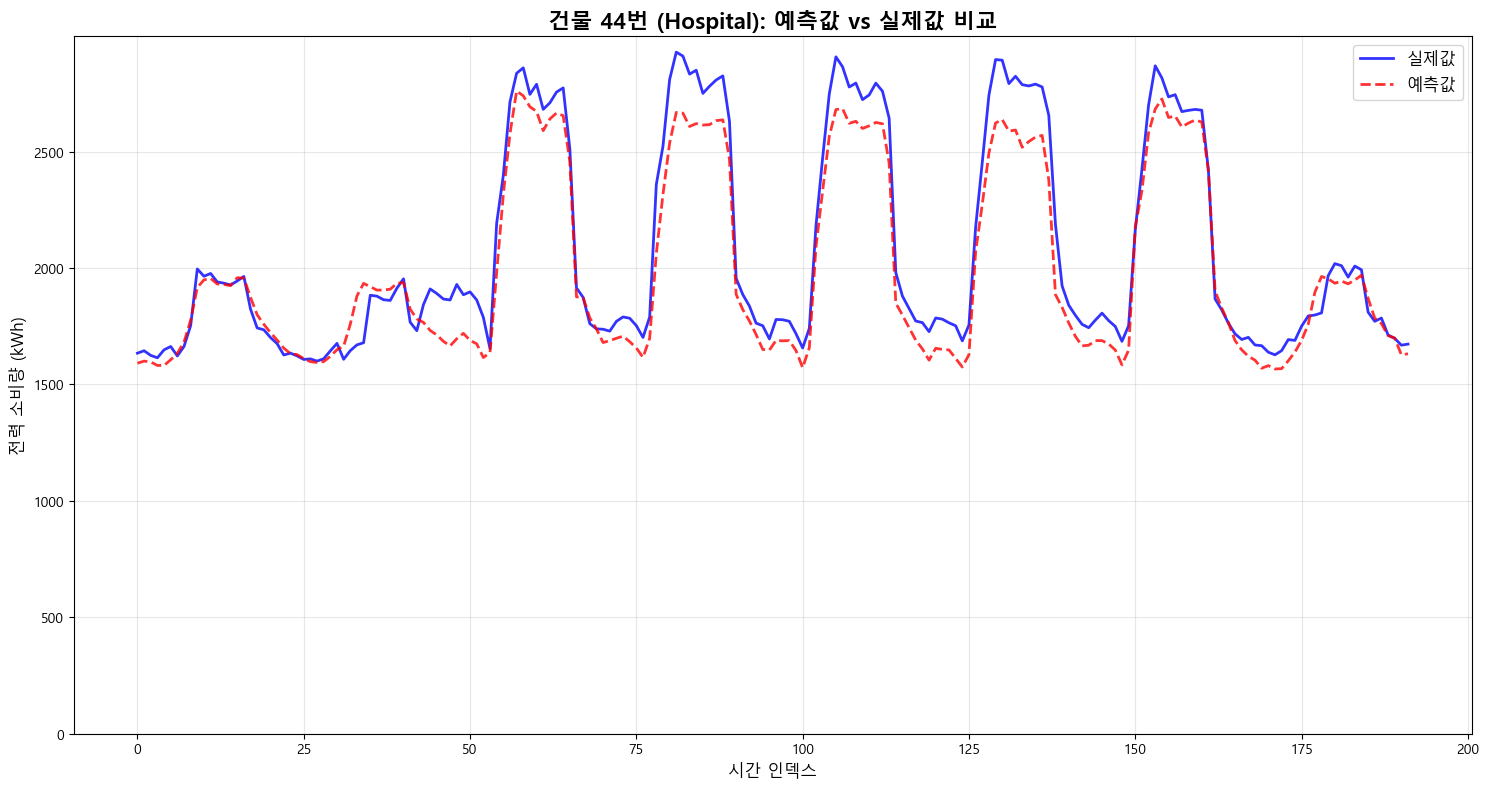

✅ 건물 44번 (Hospital) 시각화 완료
   �� 데이터 수: 192개
   �� SMAPE: 4.61
   �� MAE: 96.89 kWh
   📈 MAPE: 4.49%


In [91]:
building_visualization2(n)
n+=1

🔍 개별 건물 모델 성능 분석 및 문제 건물 식별...
�� 개별 건물 모델 성능 통계:
   총 건물 수: 100개
   전체 평균 SMAPE: 6.3148
   최고 성능 SMAPE: 0.3653
   최저 성능 SMAPE: 24.1164
   SMAPE 표준편차: 4.6664

⚠️ 평균보다 높은 SMAPE를 가진 건물들:
   건물 수: 35개
   비율: 35.0%

📈 성능별 건물 분류:
   매우 좋음 (평균의 50% 이하): 23개
   좋음 (평균의 50-100%): 42개
   보통 (평균의 100-150%): 14개
   나쁨 (평균의 150-200%): 12개
   매우 나쁨 (평균의 200% 이상): 9개

�� 문제 건물 상세 분석 (SMAPE > 6.3148):
 1. 건물 94 (Research Institute): SMAPE  24.12 (평균의  3.8배)
 2. 건물 10 (Hotel          ): SMAPE  21.68 (평균의  3.4배)
 3. 건물 23 (Research Institute): SMAPE  21.55 (평균의  3.4배)
 4. 건물 87 (University     ): SMAPE  18.34 (평균의  2.9배)
 5. 건물 100 (Hotel          ): SMAPE  17.07 (평균의  2.7배)
 6. 건물 49 (Research Institute): SMAPE  16.68 (평균의  2.6배)
 7. 건물 33 (Public         ): SMAPE  13.48 (평균의  2.1배)
 8. 건물  6 (Commercial     ): SMAPE  13.28 (평균의  2.1배)
 9. 건물 54 (Department Store): SMAPE  12.91 (평균의  2.0배)
10. 건물 46 (University     ): SMAPE  11.96 (평균의  1.9배)
11. 건물 95 (Department Store): SMAPE  11.77 (평균의  1.9배)
12. 

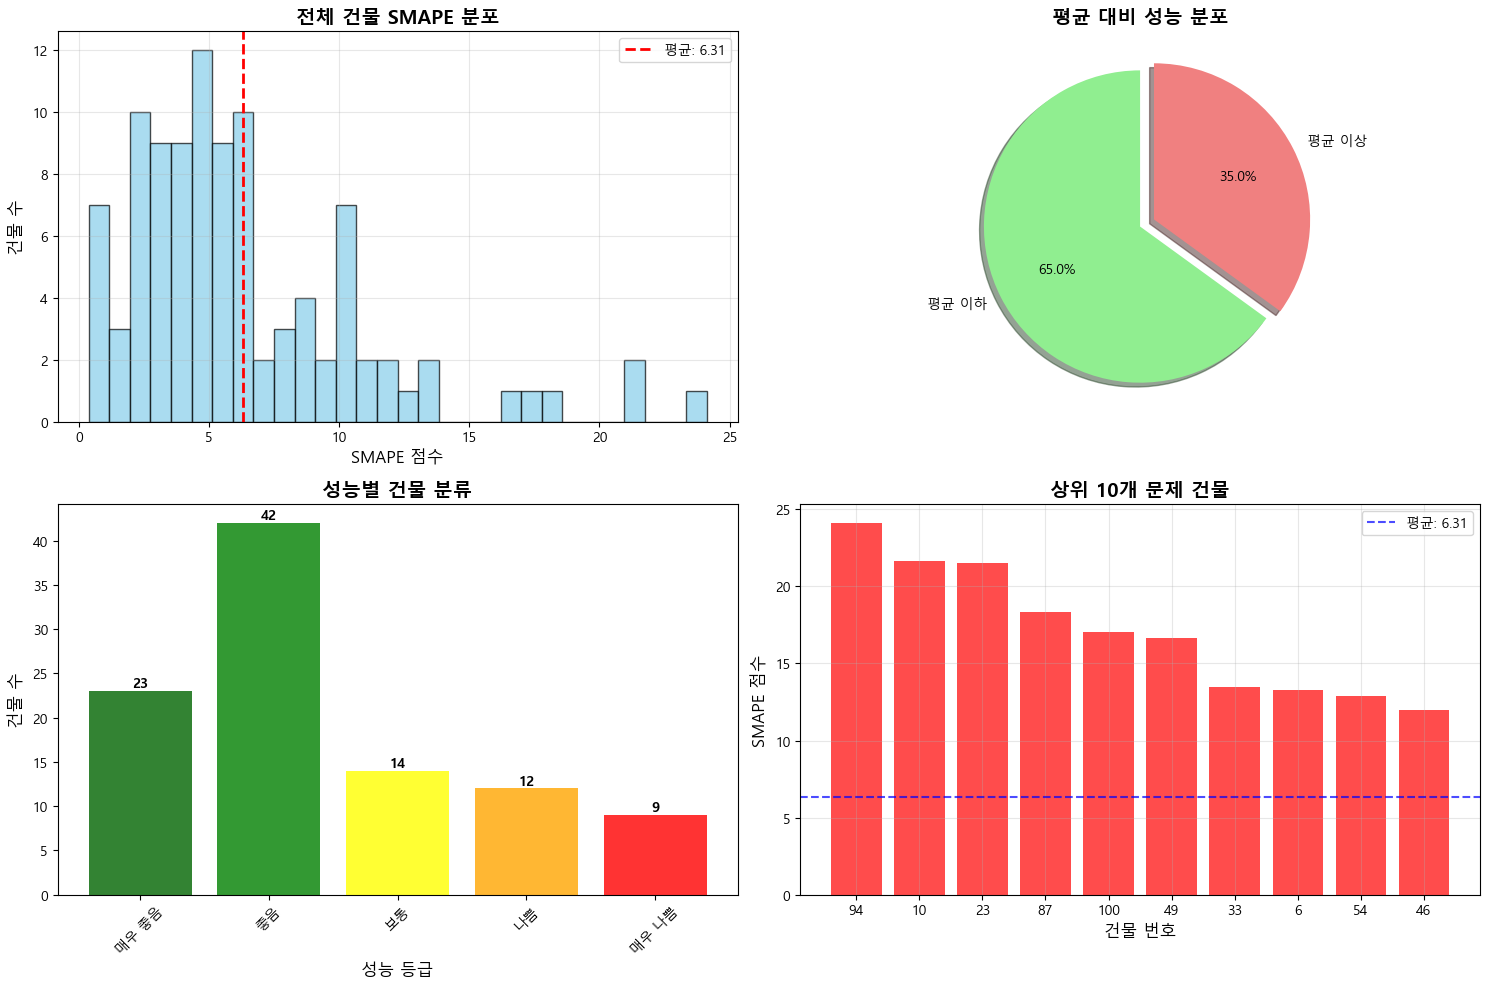


💡 문제 건물 개선 방안:
�� SMAPE가 평균보다 높은 건물들에 대한 개선 방안:

   �� Hotel 건물들 (4개):
      건물 번호: [1, 10, 77, 100]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� Commercial 건물들 (2개):
      건물 번호: [6, 86]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� Other Buildings 건물들 (4개):
      건물 번호: [7, 26, 47, 61]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� University 건물들 (3개):
      건물 번호: [8, 46, 87]
      �� 개선 방안: 학기/방학 패턴 반영, 수업 시간대 특성 고려

   �� Research Institute 건물들 (7개):
      건물 번호: [13, 15, 23, 37, 49, 53, 94]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� Department Store 건물들 (7개):
      건물 번호: [19, 27, 32, 54, 59, 79, 95]
      💡 개선 방안: 백화점 특성 반영, 휴일 패턴 강화, 계절성 피처 추가

   �� Apartment 건물들 (1개):
      건물 번호: [25]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� Public 건물들 (6개):
      건물 번호: [33, 50, 66, 68, 72, 80]
      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링

   �� Hospital 건물들 (1개):
      건물 번호: [48]
      �� 개선 방안: 응급 상황 패턴 반영, 야간 운영 특성 고려

✅ 개별 건물 모델 성능 분석 완료
📁 결과 저장: individual_building_perf

In [33]:
## 8. 개별 건물 모델 성능 분석 및 문제 건물 식별
print("🔍 개별 건물 모델 성능 분석 및 문제 건물 식별...")
print("=" * 60)

# 1. 기본 통계 분석
print("�� 개별 건물 모델 성능 통계:")
print(f"   총 건물 수: {len(individual_model_scores)}개")
print(f"   전체 평균 SMAPE: {total_individual_smape:.4f}")
print(f"   최고 성능 SMAPE: {min(individual_model_scores.values()):.4f}")
print(f"   최저 성능 SMAPE: {max(individual_model_scores.values()):.4f}")
print(f"   SMAPE 표준편차: {np.std(list(individual_model_scores.values())):.4f}")

# 2. 평균보다 높은 SMAPE를 가진 건물들 찾기
mean_smape = total_individual_smape
above_average_buildings = {}

for building_num, smape_score in individual_model_scores.items():
    if smape_score > mean_smape:
        above_average_buildings[building_num] = smape_score

print(f"\n⚠️ 평균보다 높은 SMAPE를 가진 건물들:")
print(f"   건물 수: {len(above_average_buildings)}개")
print(f"   비율: {len(above_average_buildings)/len(individual_model_scores)*100:.1f}%")

# 3. 성능별 건물 분류
performance_categories = {
    'excellent': [],      # 평균의 50% 이하 (매우 좋음)
    'good': [],           # 평균의 50-100% (좋음)
    'average': [],        # 평균의 100-150% (보통)
    'poor': [],           # 평균의 150-200% (나쁨)
    'very_poor': []       # 평균의 200% 이상 (매우 나쁨)
}

for building_num, smape_score in individual_model_scores.items():
    ratio = smape_score / mean_smape
    
    if ratio <= 0.5:
        performance_categories['excellent'].append((building_num, smape_score))
    elif ratio <= 1.0:
        performance_categories['good'].append((building_num, smape_score))
    elif ratio <= 1.5:
        performance_categories['average'].append((building_num, smape_score))
    elif ratio <= 2.0:
        performance_categories['poor'].append((building_num, smape_score))
    else:
        performance_categories['very_poor'].append((building_num, smape_score))

# 4. 성능별 분류 결과 출력
print(f"\n📈 성능별 건물 분류:")
for category, buildings in performance_categories.items():
    if buildings:
        category_names = {
            'excellent': '매우 좋음 (평균의 50% 이하)',
            'good': '좋음 (평균의 50-100%)',
            'average': '보통 (평균의 100-150%)',
            'poor': '나쁨 (평균의 150-200%)',
            'very_poor': '매우 나쁨 (평균의 200% 이상)'
        }
        print(f"   {category_names[category]}: {len(buildings)}개")

# 5. 문제 건물 상세 분석 (평균보다 높은 SMAPE)
if above_average_buildings:
    print(f"\n�� 문제 건물 상세 분석 (SMAPE > {mean_smape:.4f}):")
    print("=" * 80)
    
    # SMAPE 기준으로 정렬 (높은 순)
    sorted_problem_buildings = sorted(above_average_buildings.items(), 
                                     key=lambda x: x[1], reverse=True)
    
    # 건물 정보와 함께 출력
    for i, (building_num, smape_score) in enumerate(sorted_problem_buildings[:20], 1):  # 상위 20개
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        ratio_to_mean = smape_score / mean_smape
        
        print(f"{i:2d}. 건물 {building_num:2d} ({building_type:15s}): "
              f"SMAPE {smape_score:6.2f} (평균의 {ratio_to_mean:4.1f}배)")
    
    if len(sorted_problem_buildings) > 20:
        print(f"   ... 및 {len(sorted_problem_buildings) - 20}개 더")

# 6. 건물 유형별 성능 분석
print(f"\n🏢 건물 유형별 성능 분석:")
building_type_performance = {}

for building_num, smape_score in individual_model_scores.items():
    building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
    
    if building_type not in building_type_performance:
        building_type_performance[building_type] = []
    
    building_type_performance[building_type].append(smape_score)

for building_type, scores in building_type_performance.items():
    avg_type_smape = np.mean(scores)
    count = len(scores)
    ratio_to_overall = avg_type_smape / mean_smape
    
    performance_indicator = "🔴" if ratio_to_overall > 1.2 else "🟡" if ratio_to_overall > 1.0 else "��"
    
    print(f"   {performance_indicator} {building_type:20s}: "
          f"평균 SMAPE {avg_type_smape:6.2f} (건물 {count:2d}개, "
          f"전체 평균의 {ratio_to_overall:4.1f}배)")

# 7. 문제 건물 시각화
print(f"\n📊 문제 건물 시각화...")

# SMAPE 분포 히스토그램
plt.figure(figsize=(15, 10))

# 1. 전체 SMAPE 분포
plt.subplot(2, 2, 1)
smape_values = list(individual_model_scores.values())
plt.hist(smape_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean_smape, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_smape:.2f}')
plt.title('전체 건물 SMAPE 분포', fontsize=14, fontweight='bold')
plt.xlabel('SMAPE 점수', fontsize=12)
plt.ylabel('건물 수', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 평균 이상 vs 이하 건물 수
plt.subplot(2, 2, 2)
below_average_count = len(individual_model_scores) - len(above_average_buildings)
above_average_count = len(above_average_buildings)

labels = ['평균 이하', '평균 이상']
sizes = [below_average_count, above_average_count]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, shadow=True)
plt.title('평균 대비 성능 분포', fontsize=14, fontweight='bold')

# 3. 성능별 건물 수
plt.subplot(2, 2, 3)
category_labels = ['매우 좋음', '좋음', '보통', '나쁨', '매우 나쁨']
category_counts = [len(performance_categories[cat]) for cat in ['excellent', 'good', 'average', 'poor', 'very_poor']]
category_colors = ['darkgreen', 'green', 'yellow', 'orange', 'red']

bars = plt.bar(category_labels, category_counts, color=category_colors, alpha=0.8)
plt.title('성능별 건물 분류', fontsize=14, fontweight='bold')
plt.xlabel('성능 등급', fontsize=12)
plt.ylabel('건물 수', fontsize=12)
plt.xticks(rotation=45)

# 막대 위에 값 표시
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. 상위 문제 건물 10개
plt.subplot(2, 2, 4)
if above_average_buildings:
    top_10_problem = sorted(above_average_buildings.items(), key=lambda x: x[1], reverse=True)[:10]
    building_nums, smape_scores = zip(*top_10_problem)
    
    bars = plt.bar(range(len(building_nums)), smape_scores, color='red', alpha=0.7)
    plt.title('상위 10개 문제 건물', fontsize=14, fontweight='bold')
    plt.xlabel('건물 번호', fontsize=12)
    plt.ylabel('SMAPE 점수', fontsize=12)
    plt.xticks(range(len(building_nums)), building_nums)
    plt.axhline(mean_smape, color='blue', linestyle='--', alpha=0.7, label=f'평균: {mean_smape:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('individual_building_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. 문제 건물 개선 방안 제시
print(f"\n💡 문제 건물 개선 방안:")
print("=" * 60)

if above_average_buildings:
    print("�� SMAPE가 평균보다 높은 건물들에 대한 개선 방안:")
    
    # 건물 유형별로 그룹화
    problem_by_type = {}
    for building_num in above_average_buildings.keys():
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        if building_type not in problem_by_type:
            problem_by_type[building_type] = []
        problem_by_type[building_type].append(building_num)
    
    for building_type, buildings in problem_by_type.items():
        print(f"\n   �� {building_type} 건물들 ({len(buildings)}개):")
        print(f"      건물 번호: {buildings}")
        
        # 건물 유형별 개선 방안
        if building_type == 'Department Store':
            print(f"      💡 개선 방안: 백화점 특성 반영, 휴일 패턴 강화, 계절성 피처 추가")
        elif building_type == 'IDC':
            print(f"      💡 개선 방안: 24시간 운영 특성 반영, 부하 패턴 분석, 이상치 처리 강화")
        elif building_type == 'Hospital':
            print(f"      �� 개선 방안: 응급 상황 패턴 반영, 야간 운영 특성 고려")
        elif building_type == 'University':
            print(f"      �� 개선 방안: 학기/방학 패턴 반영, 수업 시간대 특성 고려")
        else:
            print(f"      💡 개선 방안: 건물별 특수 패턴 분석, 추가 피처 엔지니어링")

print(f"\n✅ 개별 건물 모델 성능 분석 완료")
print(f"📁 결과 저장: individual_building_performance_analysis.png")

In [93]:
print("🎯 앙상블 모델 생성 중...")
print("=" * 50)

# 앙상블 가중치 설정 (개별 건물 모델에 더 높은 가중치)
individual_weight = 0.7  # 개별 건물 모델 가중치
type_weight = 0.3        # 건물 타입별 모델 가중치

print(f"📊 앙상블 가중치:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 검증 데이터 앙상블
ensemble_oof = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# 테스트 데이터 앙상블
ensemble_predictions = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

# 앙상블 성능 계산
ensemble_smape = smape(
    Y.sort_index()["power_consumption"].values,
    ensemble_oof.sort_index().values
)

print(f"\n🏆 성능 비교:")
print(f"   건물 타입별 모델 SMAPE: {total_type_smape:.4f}")
print(f"   개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
print(f"   앙상블 모델 SMAPE: {ensemble_smape:.4f}")

# 성능 향상 확인
improvement_vs_type = total_type_smape - ensemble_smape
improvement_vs_individual = total_individual_smape - ensemble_smape

print(f"\n📈 성능 향상:")
print(f"   vs 건물 타입별: {improvement_vs_type:+.4f} SMAPE")
print(f"   vs 개별 건물: {improvement_vs_individual:+.4f} SMAPE")

if ensemble_smape < min(total_type_smape, total_individual_smape):
    print("\n🎉 앙상블이 개별 모델들보다 우수한 성능을 보입니다!")
else:
    print("\n⚠️ 앙상블 성능이 기대보다 낮습니다. 가중치 조정을 고려해보세요.")

print("✅ 앙상블 모델 생성 완료")


🎯 앙상블 모델 생성 중...
📊 앙상블 가중치:
   개별 건물 모델: 70.0%
   건물 타입별 모델: 30.0%

🏆 성능 비교:
   건물 타입별 모델 SMAPE: nan
   개별 건물 모델 SMAPE: 6.2138
   앙상블 모델 SMAPE: nan

📈 성능 향상:
   vs 건물 타입별: +nan SMAPE
   vs 개별 건물: +nan SMAPE

⚠️ 앙상블 성능이 기대보다 낮습니다. 가중치 조정을 고려해보세요.
✅ 앙상블 모델 생성 완료


In [94]:
print("📝 제출 파일 생성 중...")

# 제출 파일 생성
submission = sample_submission.copy()
submission["answer"] = ensemble_predictions.values

# 음수값 처리 (전력 소비량은 음수가 될 수 없음)
submission["answer"] = np.maximum(submission["answer"], 0)

# 결과 저장
submission.to_csv('ensemble_submission.csv', index=False)

print("✅ 제출 파일 저장: ensemble_submission.csv")

# 예측 결과 통계
print(f"\n📊 예측 결과 통계:")
print(f"   예측 평균: {submission['answer'].mean():.2f} kWh")
print(f"   예측 중앙값: {submission['answer'].median():.2f} kWh")
print(f"   예측 범위: {submission['answer'].min():.2f} ~ {submission['answer'].max():.2f} kWh")
print(f"   예측 표준편차: {submission['answer'].std():.2f} kWh")

# 제출 파일 미리보기
print(f"\n📋 제출 파일 미리보기:")
display(submission.head(10))

# 개별 모델 결과도 저장
individual_submission = sample_submission.copy()
individual_submission["answer"] = np.maximum(individual_model_predictions["answer"].values, 0)
individual_submission.to_csv('individual_model_submission.csv', index=False)

type_submission = sample_submission.copy()
type_submission["answer"] = np.maximum(type_model_predictions["answer"].values, 0)
type_submission.to_csv('type_model_submission.csv', index=False)

# 추가: 다양한 앙상블 비율의 제출 파일들도 생성 (상위 3개)
print(f"\n📁 상위 3개 앙상블 조합 제출 파일 생성...")
for i, result in enumerate(top_5_results[:3], 1):
    weight_individual = result['individual_weight']
    weight_type = result['type_weight']
    
    # 해당 비율로 앙상블 예측
    ensemble_pred = (
        individual_model_predictions["answer"] * weight_individual + 
        type_model_predictions["answer"] * weight_type
    )
    
    # 제출 파일 생성
    temp_submission = sample_submission.copy()
    temp_submission["answer"] = np.maximum(ensemble_pred.values, 0)
    filename = f'ensemble_rank{i}_{weight_individual*100:.0f}_{weight_type*100:.0f}_submission.csv'
    temp_submission.to_csv(filename, index=False)
    
    print(f"   {i}순위: {filename} (개별 {weight_individual*100:.0f}% + 타입별 {weight_type*100:.0f}%)")

print("\n✅ 모든 제출 파일 생성 완료:")
print("   - optimal_ensemble_submission.csv (최적 비율)")
print("   - individual_model_submission.csv (개별 건물 모델)")
print("   - type_model_submission.csv (타입별 모델)")
print("   - ensemble_rank1_XX_XX_submission.csv (1순위 앙상블)")
print("   - ensemble_rank2_XX_XX_submission.csv (2순위 앙상블)")
print("   - ensemble_rank3_XX_XX_submission.csv (3순위 앙상블)")


📝 제출 파일 생성 중...
✅ 제출 파일 저장: ensemble_submission.csv

📊 예측 결과 통계:
   예측 평균: 3483.06 kWh
   예측 중앙값: 2035.29 kWh
   예측 범위: 11.39 ~ 24953.94 kWh
   예측 표준편차: 3771.01 kWh

📋 제출 파일 미리보기:


,num_date_time,answer
0,1_20240825 00,4547.313916
1,1_20240825 01,4368.625928
2,1_20240825 02,4174.126416
3,1_20240825 03,4004.462329
4,1_20240825 04,4050.845361
5,1_20240825 05,3710.446289
6,1_20240825 06,3832.179395
7,1_20240825 07,4351.884277
8,1_20240825 08,4883.058154
9,1_20240825 09,6158.179346



📁 상위 3개 앙상블 조합 제출 파일 생성...


NameError: name 'top_5_results' is not defined